/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


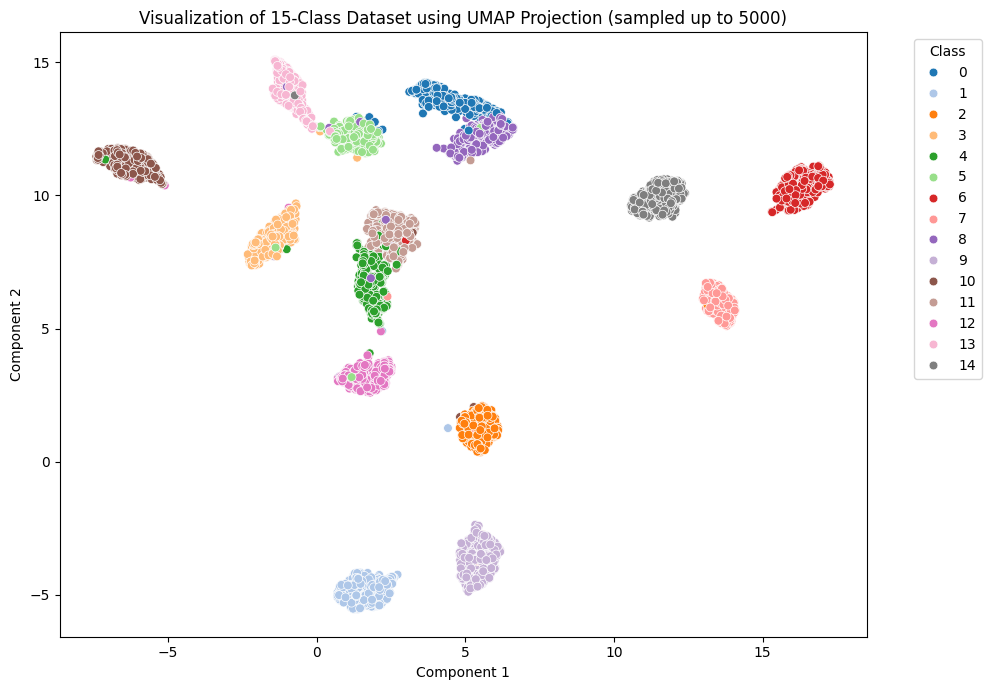

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np

# Optional: UMAP
try:
    import umap
    use_umap = True
except ImportError:
    use_umap = False

# 1. Create a synthetic classification dataset
X, y = make_classification(n_samples=50000,
                           n_features=20,
                           class_sep=2.5,
                           n_informative=18,
                           n_redundant=2,
                           n_classes=15,
                           n_clusters_per_class=1,
                           random_state=42)

# 2. Sample if using UMAP
if use_umap:
    sample_size = min(5000, len(X))
    rng = np.random.default_rng(seed=42)
    indices = rng.choice(len(X), size=sample_size, replace=False)
    X_sampled, y_sampled = X[indices], y[indices]

    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    X_reduced = reducer.fit_transform(X_sampled)
    y_reduced = y_sampled
    title = "UMAP Projection (sampled up to 5000)"
else:
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    y_reduced = y
    title = "PCA Projection (full data)"

# 3. Plot
plt.figure(figsize=(10, 7))
palette = sns.color_palette("tab20", 15)
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y_reduced, palette=palette, legend='full', s=40)
plt.title(f"Visualization of 15-Class Dataset using {title}")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [14]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification # Use make_classification
from sklearn.decomposition import PCA # Use PCA for visualization if UMAP not available
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import time # To time the tuning

# Optional: UMAP for visualization
try:
    import umap
    use_umap = True
    print("UMAP library found, will use for visualization.")
except ImportError:
    use_umap = False
    print("UMAP library not found, falling back to PCA for visualization.")


# Suppress specific warnings if needed
warnings.filterwarnings("ignore", message=".*perplexity.*")
warnings.filterwarnings("ignore", message=".*Precision and F-score are ill-defined.*")

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




UMAP library found, will use for visualization.


In [15]:
# --- Parameters ---
# Dataset Parameters
N_SAMPLES = 50000
N_FEATURES = 20
N_CLASSES_TOTAL = 15
N_CLUSTERS_PER_CLASS = 1
CLASS_SEP = 2.5 # Adjust separation

# OSR Split Parameters
NUM_KNOWN_CLASSES = 5 # Randomly select 5 known classes
NUM_UNKNOWN_TRAIN_CLASSES = 2 # Use 2 of the remaining classes as training unknowns
NUM_UNKNOWN_TEST_CLASSES = N_CLASSES_TOTAL - NUM_KNOWN_CLASSES - NUM_UNKNOWN_TRAIN_CLASSES # Rest are test unknowns (15 - 5 - 2 = 8)
UNKNOWN_LABEL_MAP = NUM_KNOWN_CLASSES # Label assigned to all unknown samples (5)

# Model & Training Parameters
BATCH_SIZE = 128 # Increased batch size slightly
LEARNING_RATE = 0.001
EPOCHS = 50 # Adjust based on convergence with synthetic data
EPOCHS_TUNE = 20 # Reduced epochs for faster hyperparameter tuning
FEATURE_DIM = 64 # Dimension of the feature vector f(x)
HIDDEN_DIM1 = 256 # Slightly larger network for potentially more complex data
HIDDEN_DIM2 = 128

# Original Objectosphere parameters (as a baseline reference)
LAMBDA_OBJ_ORIG = 0.1 # Weight for the magnitude penalty term
XI_OBJ_ORIG = 20.0 # Margin for objectosphere (target magnitude boundary)

# Hyperparameter Grid for Tuning Objectosphere
PARAM_GRID = {
    'lambda_obj': [0.05, 0.1, 0.5, 1.0], # Adjusted grid slightly
    'xi_obj': [1.0, 5.0, 10.0, 20.0] # Adjusted grid slightly
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")



Using device: cpu


In [16]:
# --- 0. Generate Synthetic Data ---
def generate_data(n_samples, n_features, n_classes, n_clusters, class_sep, seed):
    print("\n--- Generating Synthetic Data ---")
    X, y = make_classification(n_samples=n_samples,
                               n_features=n_features,
                               class_sep=class_sep,
                               n_informative=max(5, int(n_features*0.8)), # Ensure enough informative features
                               n_redundant=max(1, int(n_features*0.1)),
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               random_state=seed)
    print(f"Generated X shape: {X.shape}, y shape: {y.shape}")
    print(f"Unique original classes: {np.unique(y)}")
    return X, y

# --- 1. Load and Prepare Data (Modified for Synthetic Data) ---
def load_and_prepare_data(X_orig, y_orig, n_classes_total, num_known_classes, num_unknown_train, num_unknown_test, unknown_label_map, seed):
    print("\n--- Preparing Data for OSR ---")
    rng = np.random.default_rng(seed)
    all_original_classes = np.arange(n_classes_total)

    # Randomly select known classes
    known_classes_indices = rng.choice(all_original_classes, size=num_known_classes, replace=False)
    known_classes_indices.sort()

    # Identify remaining unknown classes
    unknown_classes_indices_all = np.setdiff1d(all_original_classes, known_classes_indices)

    # Split remaining unknowns into train and test unknowns
    unknown_train_indices = rng.choice(unknown_classes_indices_all, size=num_unknown_train, replace=False)
    unknown_train_indices.sort()
    unknown_test_indices = np.setdiff1d(unknown_classes_indices_all, unknown_train_indices)
    unknown_test_indices.sort()

    print(f"Total Original Classes: {n_classes_total}")
    print(f"Selected Known Classes (Original Indices): {known_classes_indices}")
    print(f"Selected Unknown Train Classes (Original Indices): {unknown_train_indices}")
    print(f"Selected Unknown Test Classes (Original Indices): {unknown_test_indices}")
    print(f"Number of Known Classes for Model: {num_known_classes}")
    print(f"Internal Label for Unknowns: {unknown_label_map}")

    # Create mapping from original class index to new label
    # Known classes map 0 to num_known_classes-1
    # All unknown classes map to unknown_label_map
    label_mapping = {}
    for i, orig_idx in enumerate(known_classes_indices):
        label_mapping[orig_idx] = i
    for orig_idx in unknown_classes_indices_all:
        label_mapping[orig_idx] = unknown_label_map

    # Apply mapping
    y_mapped = np.array([label_mapping[orig_y] for orig_y in y_orig])

    # Separate data based on ORIGINAL class index for splitting purposes
    known_mask = np.isin(y_orig, known_classes_indices)
    unknown_train_mask = np.isin(y_orig, unknown_train_indices)
    unknown_test_mask = np.isin(y_orig, unknown_test_indices)

    X_known = X_orig[known_mask]
    y_known_orig = y_orig[known_mask] # Keep original y for potential analysis
    y_known_mapped = y_mapped[known_mask] # Use mapped y for training/eval

    X_unknown_train = X_orig[unknown_train_mask]
    y_unknown_train_mapped = y_mapped[unknown_train_mask]

    X_unknown_test = X_orig[unknown_test_mask]
    y_unknown_test_mapped = y_mapped[unknown_test_mask]


    # --- Prepare Training/Validation Pool (Knowns + Training Unknowns) ---
    X_pool = np.vstack((X_known, X_unknown_train))
    y_pool = np.concatenate((y_known_mapped, y_unknown_train_mapped))

    # Split pool into Training and Validation sets
    try:
        unique_labels_pool, counts = np.unique(y_pool, return_counts=True)
        if np.any(counts < 2):
             print("Warning: Stratification might fail (class count < 2 in pool). Using non-stratified split.")
             X_train, X_val, y_train, y_val = train_test_split( X_pool, y_pool, test_size=0.25, random_state=seed ) # Slightly larger validation set
        else:
             X_train, X_val, y_train, y_val = train_test_split( X_pool, y_pool, test_size=0.25, random_state=seed, stratify=y_pool )
    except ValueError as e:
        print(f"Warning: Stratification failed ({e}). Performing non-stratified split.")
        X_train, X_val, y_train, y_val = train_test_split( X_pool, y_pool, test_size=0.25, random_state=seed )

    print(f"Train Pool Split: X_train={X_train.shape}, y_train={y_train.shape} | X_val={X_val.shape}, y_val={y_val.shape}")
    print(f"Unique labels in y_train: {np.unique(y_train)}")
    print(f"Unique labels in y_val: {np.unique(y_val)}")

    # Check if validation set has unknowns (important for tuning)
    if not (np.unique(y_val) == unknown_label_map).any():
         print("\nWARNING: Validation set contains NO unknown samples (label={unknown_label_map}). AUROC calculation for tuning might not be meaningful.")

    # --- Prepare Final Test Set (Knowns from Val + Testing Unknowns) ---
    # Take a subset of knowns from the validation set to balance with test unknowns
    num_unknown_test_samples = len(X_unknown_test)
    val_known_mask = y_val < num_known_classes
    X_val_known = X_val[val_known_mask]
    y_val_known = y_val[val_known_mask]

    if len(X_val_known) > 0:
        num_known_test_samples = min(num_unknown_test_samples, len(X_val_known)) # Balance or take all available knowns
        if num_known_test_samples > 0:
            test_known_indices = rng.choice(len(X_val_known), size=num_known_test_samples, replace=False)
            X_test_known = X_val_known[test_known_indices]
            y_test_known = y_val_known[test_known_indices]
        else:
            X_test_known = np.array([]).reshape(0, X_orig.shape[1])
            y_test_known = np.array([])
    else:
        print("Warning: No known samples available in validation set to add to test set.")
        X_test_known = np.array([]).reshape(0, X_orig.shape[1])
        y_test_known = np.array([])


    # Combine known test samples and U_test samples
    test_samples_exist = False
    if num_unknown_test_samples > 0 and len(y_test_known) > 0:
        X_test = np.vstack((X_test_known, X_unknown_test))
        y_test = np.concatenate((y_test_known, y_unknown_test_mapped))
        test_samples_exist = True
    elif num_unknown_test_samples > 0: # Only unknowns in test set
        X_test = X_unknown_test
        y_test = y_unknown_test_mapped
        test_samples_exist = True
    elif len(y_test_known) > 0: # Only knowns in test set
        X_test = X_test_known
        y_test = y_test_known
        test_samples_exist = True
    else: # No test samples
        print("Error: No samples available for the final test set.")
        X_test = np.array([]).reshape(0, X_orig.shape[1])
        y_test = np.array([])

    print(f"Final Test Set: X_test={X_test.shape}, y_test={y_test.shape}")
    print(f"Unique labels in y_test: {np.unique(y_test)}")


    # --- Scale features ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    if test_samples_exist:
        X_test = scaler.transform(X_test)

    # --- Create DataLoaders ---
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)) if test_samples_exist else None

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) if test_dataset else None

    if not test_loader:
        print("\nWARNING: Test loader is empty. Final evaluation cannot proceed.")


    return (train_loader, val_loader, test_loader, X_orig.shape[1], scaler,
            known_classes_indices, unknown_train_indices, unknown_test_indices)




In [17]:
# --- 1b. Plotting Function for Class Split ---
def plot_class_split_visualization(X_orig, y_orig, known_indices, unknown_train_indices, unknown_test_indices, use_umap_flag=use_umap):
    """Visualizes the original data colored by its role (Known, Unknown Train, Unknown Test)."""
    print("\n--- Visualizing Known/Unknown Split ---")

    # Determine dimensionality reduction method
    if use_umap_flag:
        try:
            sample_size = min(5000, len(X_orig))
            rng = np.random.default_rng(seed=SEED)
            indices = rng.choice(len(X_orig), size=sample_size, replace=False)
            X_sampled, y_sampled = X_orig[indices], y_orig[indices]

            reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=SEED)
            X_reduced = reducer.fit_transform(X_sampled)
            y_reduced_orig = y_sampled
            title_suffix = "UMAP Projection (Sampled)"
        except Exception as e:
            print(f"UMAP failed ({e}), falling back to PCA.")
            pca = PCA(n_components=2, random_state=SEED)
            X_reduced = pca.fit_transform(X_orig)
            y_reduced_orig = y_orig
            title_suffix = "PCA Projection (Full Data)"
            use_umap_flag = False # Ensure correct title usage
    else:
        pca = PCA(n_components=2, random_state=SEED)
        X_reduced = pca.fit_transform(X_orig)
        y_reduced_orig = y_orig
        title_suffix = "PCA Projection (Full Data)"

    # Assign role based on original class index
    roles = []
    for y_i in y_reduced_orig:
        if y_i in known_indices:
            roles.append(f"Known (Orig: {y_i})")
        elif y_i in unknown_train_indices:
            roles.append(f"Unknown - Train (Orig: {y_i})")
        elif y_i in unknown_test_indices:
            roles.append(f"Unknown - Test (Orig: {y_i})")
        else:
            roles.append("Other") # Should not happen with correct logic

    df_plot = pd.DataFrame(X_reduced, columns=['Component 1', 'Component 2'])
    df_plot['Original Class'] = y_reduced_orig
    df_plot['Role'] = roles

    # Define colors for roles
    role_palette = {
        'Known': 'blue',
        'Unknown - Train': 'orange',
        'Unknown - Test': 'red'
    }
    # Generate colors dynamically to handle the detailed labels
    unique_roles = sorted(df_plot['Role'].unique())
    detailed_palette = {}
    for role in unique_roles:
        if role.startswith("Known"):
            detailed_palette[role] = role_palette['Known']
        elif role.startswith("Unknown - Train"):
             detailed_palette[role] = role_palette['Unknown - Train']
        elif role.startswith("Unknown - Test"):
             detailed_palette[role] = role_palette['Unknown - Test']
        else:
             detailed_palette[role] = 'grey'


    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df_plot, x='Component 1', y='Component 2', hue='Role', palette=detailed_palette, s=30, alpha=0.7) # Use Role for color
    plt.title(f"Data Visualization by Assigned Role ({title_suffix})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    # Adjust legend - might become very large if plotting individual classes
    handles, labels = plt.gca().get_legend_handles_labels()
    # Create a simplified legend for roles
    simplified_handles = []
    simplified_labels = []
    added_roles = set()
    for handle, label in zip(handles, labels):
        role_base = label.split('(')[0].strip()
        if role_base not in added_roles:
            simplified_handles.append(handle)
            simplified_labels.append(role_base)
            added_roles.add(role_base)

    plt.legend(simplified_handles, simplified_labels, title='Role', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show(block=False)
    plt.pause(1)



In [18]:
# --- 2. Model Architecture ---
# (MLP class)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, feature_dim, num_known_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4) # Slightly increased dropout
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4) # Slightly increased dropout
        # Feature extraction layer
        self.feature_layer = nn.Linear(hidden_dim2, feature_dim)
        self.relu3 = nn.ReLU()
        # Final classification layer
        self.classifier = nn.Linear(feature_dim, num_known_classes, bias=False) # Bias=False for EOS/Objecto

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        features = self.relu3(self.feature_layer(x)) # f(x)
        logits = self.classifier(features) # Logits for known classes
        return logits, features



In [19]:
# --- 3. Loss Function Implementation ---
# (EntropicOpenSetLoss and ObjectosphereLoss classes)

class EntropicOpenSetLoss(nn.Module):
    def __init__(self, num_known_classes):
        super(EntropicOpenSetLoss, self).__init__()
        self.num_known_classes = num_known_classes
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none') # Use 'none' for manual averaging

    def forward(self, logits, labels):
        known_mask = labels < self.num_known_classes
        unknown_mask = labels == self.num_known_classes # Assumes unknown label is num_known_classes

        loss_known = torch.tensor(0.0, device=logits.device)
        loss_unknown = torch.tensor(0.0, device=logits.device)
        count_known = known_mask.sum()
        count_unknown = unknown_mask.sum()

        if count_known > 0:
            loss_known = self.cross_entropy(logits[known_mask], labels[known_mask]).sum()

        if count_unknown > 0:
            logits_unknown = logits[unknown_mask]
            # Maximize entropy for unknowns == minimize average negative log probability
            log_probs_unknown = torch.log_softmax(logits_unknown, dim=1)
            loss_unknown = -log_probs_unknown.mean(dim=1).sum() # Maximize entropy by minimizing this

        # Average over the entire batch size
        batch_size = len(labels)
        if batch_size > 0:
            total_loss = (loss_known + loss_unknown) / batch_size
        else:
            total_loss = torch.tensor(0.0, device=logits.device)

        return total_loss

class ObjectosphereLoss(nn.Module):
    def __init__(self, num_known_classes, lambda_obj, xi_obj):
        super(ObjectosphereLoss, self).__init__()
        self.num_known_classes = num_known_classes
        self.lambda_obj = lambda_obj
        self.xi_obj = xi_obj
        # This loss *builds upon* the Entropic Open Set loss from the example code
        self.entropic_loss = EntropicOpenSetLoss(num_known_classes)
        self.epsilon = 1e-6 # For numerical stability

    def forward(self, logits, features, labels):
      je_loss = self.entropic_loss(logits, labels)

      known_mask = labels != self.num_known_classes
      unknown_mask = labels == self.num_known_classes

      jr_penalty = torch.tensor(0.0, device=logits.device)

      # Penalty for known samples: max(0, xi - ||F(x)||)^2
      if known_mask.sum() > 0:
          features_known = features[known_mask]
          mag_known = torch.norm(features_known, p=2, dim=1)
          penalty_known = torch.clamp(self.xi_obj - mag_known, min=0) ** 2
          jr_penalty += self.lambda_obj * penalty_known.mean()

      # Penalty for unknown samples: ||F(x)||^2
      if unknown_mask.sum() > 0:
          features_unknown = features[unknown_mask]
          mag_unknown = torch.norm(features_unknown, p=2, dim=1)
          penalty_unknown = mag_unknown ** 2
          jr_penalty += self.lambda_obj * penalty_unknown.mean()

      total_loss = je_loss + jr_penalty
      return total_loss



In [20]:
# --- 4. Training Loop ---
# (train_model)
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, loss_type='baseline', model_label="Model", verbose=True, num_known_classes=NUM_KNOWN_CLASSES):
    model.to(device)
    best_val_loss = float('inf')
    if verbose:
        print(f"\n--- Training Model ({model_label} - {loss_type.upper()}) ---") # Added model label

    for epoch in range(epochs):
        model.train()
        train_loss_epoch = 0.0
        correct_train_known = 0
        total_train_known = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            logits, features = model(inputs)

            # --- Loss Calculation ---
            known_mask_batch = labels < num_known_classes
            if loss_type == 'baseline':
                if not known_mask_batch.any(): continue # Skip batch if no knowns
                loss = criterion(logits[known_mask_batch], labels[known_mask_batch])
            elif loss_type == 'eos':
                loss = criterion(logits, labels)
            elif loss_type == 'objectosphere':
                loss = criterion(logits, features, labels)
            else:
                 raise ValueError("Unknown loss_type")

            loss.backward()
            optimizer.step()

            train_loss_epoch += loss.item() * inputs.size(0) # Accumulate loss scaled by batch size

            # --- Training Accuracy (on knowns only) ---
            if known_mask_batch.any():
                _, predicted = torch.max(logits[known_mask_batch].data, 1)
                total_train_known += labels[known_mask_batch].size(0)
                correct_train_known += (predicted == labels[known_mask_batch]).sum().item()


        # Calculate average loss for the epoch
        num_samples_processed = len(train_loader.sampler) if hasattr(train_loader, 'sampler') and train_loader.drop_last else len(train_loader.dataset) # More robust way
        if num_samples_processed > 0:
             train_loss_epoch /= num_samples_processed
        else:
             train_loss_epoch = 0

        train_acc_known = 100. * correct_train_known / total_train_known if total_train_known > 0 else 0

        # --- Validation ---
        model.eval()
        val_loss_epoch = 0.0
        correct_val_known = 0
        total_val_known = 0
        if val_loader is not None and len(val_loader.dataset) > 0: # Check if validation is possible
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logits, features = model(inputs)

                    known_mask_batch = labels < num_known_classes

                    # --- Validation Loss (use same logic as training for comparability) ---
                    if loss_type == 'baseline':
                        if not known_mask_batch.any(): continue
                        loss = criterion(logits[known_mask_batch], labels[known_mask_batch])
                    elif loss_type == 'eos':
                        loss = criterion(logits, labels)
                    elif loss_type == 'objectosphere':
                        loss = criterion(logits, features, labels)
                    val_loss_epoch += loss.item() * inputs.size(0)

                    # --- Validation Accuracy (on knowns only) ---
                    if known_mask_batch.any():
                        _, predicted = torch.max(logits[known_mask_batch].data, 1)
                        total_val_known += labels[known_mask_batch].size(0)
                        correct_val_known += (predicted == labels[known_mask_batch]).sum().item()

            if len(val_loader.dataset)>0:
                val_loss_epoch /= len(val_loader.dataset)
            else:
                val_loss_epoch = 0

            val_acc_known = 100. * correct_val_known / total_val_known if total_val_known > 0 else 0

            # Reduced print frequency if verbose=True
            if verbose and ((epoch + 1) % 10 == 0 or epoch == 0 or epoch == epochs -1) :
                 print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss_epoch:.4f} | Train Acc (K): {train_acc_known:.2f}% | Val Loss: {val_loss_epoch:.4f} | Val Acc (K): {val_acc_known:.2f}%")

            if val_loss_epoch < best_val_loss:
                best_val_loss = val_loss_epoch
                # Optional: Save best model checkpoint
                # torch.save(model.state_dict(), f'best_model_{model_label}_{loss_type}.pth')
        else: # No validation loader
             if verbose and ((epoch + 1) % 10 == 0 or epoch == 0 or epoch == epochs -1) :
                 print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss_epoch:.4f} | Train Acc (K): {train_acc_known:.2f}% | Val Loss: N/A | Val Acc (K): N/A")


    if verbose:
        print(f"Training finished for {model_label}.")
    return model # Return trained model




In [21]:
# --- 5. Evaluation ---
# (evaluate_openset)
def evaluate_openset(model, test_loader, device, num_known_classes, unknown_label, model_label="Model"):
    # Check if test_loader is valid
    if not test_loader:
        print(f"Evaluation skipped for {model_label}: Test loader is empty.")
        # Return a dictionary with default/empty values
        return {
            "known_accuracy": 0.0, "auroc": 0.0, "f1_unknown": 0.0,
            "classification_report_openset": "N/A - No test data",
            "labels": np.array([]), "preds_class": np.array([]),
            "msp": np.array([]), "features": np.array([]),
            "logits": np.array([]), "openset_true": np.array([]),
            "openset_pred": np.array([]), "openset_scores": np.array([])
        }
    print(f"\n--- Evaluating {model_label} ---")
    model.eval()
    all_labels = []
    all_preds_class = [] # Predicted known class index
    all_msp = [] # Maximum Softmax Probability
    all_features = []
    all_logits = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            logits, features = model(inputs)
            softmax_scores = torch.softmax(logits, dim=1)
            msp, predicted_class = torch.max(softmax_scores, dim=1)

            all_labels.extend(labels.numpy())
            all_preds_class.extend(predicted_class.cpu().numpy())
            all_msp.extend(msp.cpu().numpy())
            all_features.extend(features.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds_class = np.array(all_preds_class)
    all_msp = np.array(all_msp)
    all_features = np.array(all_features)
    all_logits = np.array(all_logits)

    # Separate known and unknown samples from the test set
    known_mask_test = all_labels < num_known_classes
    unknown_mask_test = all_labels == unknown_label

    results = {
        "known_accuracy": 0.0, "auroc": 0.0, "f1_unknown": 0.0,
        "classification_report_openset": "N/A", "labels": all_labels,
        "preds_class": all_preds_class, "msp": all_msp, "features": all_features,
        "logits": all_logits, "openset_true": np.array([]),
        "openset_pred": np.array([]), "openset_scores": np.array([])
    }

    # --- Overall Accuracy on Known Classes ---
    if known_mask_test.any():
        known_labels_true = all_labels[known_mask_test]
        known_labels_pred = all_preds_class[known_mask_test]
        results["known_accuracy"] = accuracy_score(known_labels_true, known_labels_pred)
        print(f"\n--- {model_label}: Classification Report (Known Classes Only - Mapped Labels 0-{num_known_classes-1}) ---")
        target_labels = np.arange(num_known_classes)
        present_labels = np.unique(np.concatenate((known_labels_true, known_labels_pred)))
        report_labels = [l for l in target_labels if l in present_labels]
        if not report_labels:
             print("No known class predictions/labels found for report.")
        else:
             print(classification_report(known_labels_true, known_labels_pred, labels=report_labels, zero_division=0))
    else:
        print(f"Warning ({model_label}): No known samples in the test set for accuracy calculation.")

    # --- Open-Set Evaluation (Known vs. Unknown detection) ---
    if unknown_mask_test.any() and known_mask_test.any():
        openset_true_labels = np.where(unknown_mask_test, 1, 0)
        openset_scores = 1.0 - all_msp
        results["openset_true"] = openset_true_labels
        results["openset_scores"] = openset_scores

        try:
            if len(np.unique(openset_true_labels)) > 1:
                 auroc = roc_auc_score(openset_true_labels, openset_scores)
                 results["auroc"] = auroc
            else:
                 print(f"Warning ({model_label}): Only one class ({np.unique(openset_true_labels)[0]}) present in open-set true labels. AUROC is not defined.")
                 results["auroc"] = 0.5
        except ValueError as e:
            print(f"Warning ({model_label}): Could not calculate AUROC. Error: {e}")
            results["auroc"] = 0.5

        known_scores = openset_scores[known_mask_test]
        if len(known_scores) > 0:
            threshold = np.percentile(known_scores, 95)
        else:
             threshold = np.percentile(openset_scores, 50) if len(openset_scores) > 0 else 0.5
        print(f"{model_label} Open-Set Threshold (based on 1-MSP, keeping 95% knowns): {threshold:.4f}")

        openset_pred_labels = (openset_scores > threshold).astype(int)
        results["openset_pred"] = openset_pred_labels
        print(f"\n--- {model_label}: Open-Set Classification Report (0=Known, 1=Unknown) ---")
        report_str = classification_report(openset_true_labels, openset_pred_labels, labels=[0, 1], target_names=['Known', 'Unknown'], zero_division=0)
        print(report_str)
        results["classification_report_openset"] = report_str
        report_dict = classification_report(openset_true_labels, openset_pred_labels, labels=[0, 1], target_names=['Known', 'Unknown'], output_dict=True, zero_division=0)
        if 'Unknown' in report_dict:
             results["f1_unknown"] = report_dict['Unknown']['f1-score']
        else:
             print(f"Warning ({model_label}): 'Unknown' class not found in open-set classification report dictionary.")
    elif not unknown_mask_test.any():
         print(f"Warning ({model_label}): No unknown samples in the test set for open-set evaluation.")
    elif not known_mask_test.any():
         print(f"Warning ({model_label}): No known samples in the test set for open-set evaluation.")

    print(f"{model_label} - Final Known Accuracy: {results['known_accuracy']:.4f}")
    print(f"{model_label} - Final AUROC (Known vs Unknown): {results['auroc']:.4f}")
    print(f"{model_label} - Final F1 Score (Unknown Class): {results['f1_unknown']:.4f}")
    return results


# --- Validation Performance Helper (for tuning) ---
# (get_validation_performance)
def get_validation_performance(model, val_loader, device, num_known_classes, unknown_label):
    """Evaluates the model on the validation set and returns key metrics."""
    model.eval()
    all_labels = []
    all_msp = []

    if not val_loader or len(val_loader.dataset) == 0:
         return {"val_auroc": 0.0} # Return default bad values

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            logits, _ = model(inputs) # Don't need features for this evaluation metric
            softmax_scores = torch.softmax(logits, dim=1)
            msp, _ = torch.max(softmax_scores, dim=1)

            all_labels.extend(labels.numpy())
            all_msp.extend(msp.cpu().numpy())

    all_labels = np.array(all_labels)
    all_msp = np.array(all_msp)

    known_mask_val = all_labels < num_known_classes
    unknown_mask_val = all_labels == unknown_label

    val_auroc = 0.5 # Default if cannot compute

    # Calculate AUROC if possible
    if unknown_mask_val.any() and known_mask_val.any():
        openset_true_labels_val = np.where(unknown_mask_val, 1, 0)
        if len(np.unique(openset_true_labels_val)) > 1: # Check if both classes are present
            openset_scores_val = 1.0 - all_msp
            try:
                val_auroc = roc_auc_score(openset_true_labels_val, openset_scores_val)
            except ValueError:
                pass # Keep default val_auroc = 0.5
        # else: # Only one class present in validation unknowns/knowns
              # print("Warning (get_validation_performance): Only one class (known or unknown) present in val set. AUROC is undefined.")

    return {"val_auroc": val_auroc}




In [22]:
# --- 6. Visualization ---
# (Plotting functions remain the same, use NUM_KNOWN_CLASSES correctly)
# plot_tsne, plot_msp_histogram, plot_feature_magnitude_histogram functions are unchanged

def plot_tsne(features, labels, num_known_classes, unknown_label, title):
    print(f"\nGenerating t-SNE plot: {title}")
    if features is None or features.shape[0] == 0:
        print("Skipping t-SNE plot: No features provided.")
        return
    if len(features) < 5:
        print("Warning: Not enough samples for t-SNE, skipping plot.")
        return
    perplexity_value = min(30.0, max(5.0, len(features) / 4.0))
    perplexity_value = min(perplexity_value, len(features) - 1)
    if perplexity_value <= 1:
        print("Warning: Perplexity too low for t-SNE (<1), skipping plot.")
        return

    tsne = TSNE(n_components=2, random_state=SEED, perplexity=perplexity_value, n_iter=350, init='pca', learning_rate='auto')
    try:
        tsne_results = tsne.fit_transform(features)
    except Exception as e:
        print(f"Error during t-SNE fitting: {e}. Skipping plot.")
        return

    df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    df_tsne['Mapped Label'] = labels
    # Create a meaningful label string
    label_map_plot = {i: f'Known {i}' for i in range(num_known_classes)}
    label_map_plot[unknown_label] = 'Unknown'
    df_tsne['Class Label'] = df_tsne['Mapped Label'].map(label_map_plot).fillna('Other')


    plt.figure(figsize=(10, 8))
    unique_labels = sorted(df_tsne['Class Label'].unique())
    palette = {}
    known_colors = sns.color_palette("viridis", num_known_classes)
    color_idx = 0
    for lbl in unique_labels:
        if 'Unknown' in lbl or 'Other' in lbl:
            palette[lbl] = 'red'
        else:
            palette[lbl] = known_colors[color_idx % len(known_colors)]
            color_idx += 1

    sns.scatterplot(
        x="TSNE1", y="TSNE2", hue="Class Label", hue_order=unique_labels, palette=palette,
        style="Class Label", markers={lbl: ('o' if 'Known' in lbl else 'X') for lbl in unique_labels},
        s=50, data=df_tsne, legend="full", alpha=0.8
    )
    plt.title(f't-SNE Visualization of Deep Features - {title}')
    plt.xlabel("TSNE Component 1")
    plt.ylabel("TSNE Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show(block=False)
    plt.pause(1)

def plot_msp_histogram(msp_scores, labels, num_known_classes, unknown_label, title):
    print(f"\nGenerating MSP Histogram: {title}")
    if msp_scores is None or len(msp_scores) == 0:
         print("Skipping MSP Histogram: No scores provided.")
         return

    known_mask = labels < num_known_classes
    unknown_mask = labels == unknown_label
    msp_known = msp_scores[known_mask]
    msp_unknown = msp_scores[unknown_mask]

    plt.figure(figsize=(8, 5))
    if len(msp_known) > 0:
         sns.histplot(msp_known, bins=30, color='blue', label='Known Samples', kde=True, stat='density', alpha=0.6)
    else: print("Warning: No known samples in test set for MSP histogram.")
    if len(msp_unknown) > 0:
        sns.histplot(msp_unknown, bins=30, color='red', label='Unknown Samples', kde=True, stat='density', alpha=0.6)
    else: print("Warning: No unknown samples in the test set for MSP histogram.")

    plt.title(f'Histogram of Max Softmax Probability (MSP) - {title}')
    plt.xlabel('Maximum Softmax Probability (MSP)')
    plt.ylabel('Density')
    plt.xlim(0, 1.05)
    if len(msp_known) > 0 or len(msp_unknown) > 0: plt.legend()
    plt.show(block=False); plt.pause(1)

def plot_feature_magnitude_histogram(features, labels, num_known_classes, unknown_label, title, xi_obj=None):
    print(f"\nGenerating Feature Magnitude Histogram: {title}")
    if features is None or features.shape[0] == 0:
        print("Skipping Feature Magnitude Histogram: No features provided.")
        return

    known_mask = labels < num_known_classes
    unknown_mask = labels == unknown_label
    magnitudes = np.linalg.norm(features, axis=1)
    mags_known = magnitudes[known_mask]
    mags_unknown = magnitudes[unknown_mask]

    plt.figure(figsize=(8, 5))
    if len(mags_known) > 0:
        sns.histplot(mags_known, bins=30, color='blue', label='Known Samples', kde=True, stat='density', alpha=0.6)
    else: print("Warning: No known samples in test set for magnitude histogram.")
    if len(mags_unknown) > 0:
        sns.histplot(mags_unknown, bins=30, color='red', label='Unknown Samples', kde=True, stat='density', alpha=0.6)
    else: print("Warning: No unknown samples in the test set for magnitude histogram.")

    if xi_obj is not None:
        plt.axvline(xi_obj, color='green', linestyle='--', label=f'Objectosphere Margin (ξ={xi_obj:.1f})')

    plt.title(f'Histogram of Deep Feature Magnitudes - {title}')
    plt.xlabel('Feature Magnitude ||f(x)||₂')
    plt.ylabel('Density')
    if len(mags_known) > 0 or len(mags_unknown) > 0: plt.legend()
    plt.show(block=False); plt.pause(1)




In [23]:
# --- 7. Hyperparameter Tuning Function ---
# (tune_objectosphere_hyperparameters)
def tune_objectosphere_hyperparameters(param_grid, input_dim, train_loader, val_loader, device, num_known_classes, unknown_label, epochs_tune):
    print("\n" + "="*30 + " OBJECTOSPHERE HYPERPARAMETER TUNING " + "="*30)
    best_val_auroc = -1.0 # Initialize with a value lower than possible AUROC
    best_params = {'lambda_obj': None, 'xi_obj': None}
    tuning_results = []

    total_combinations = len(param_grid['lambda_obj']) * len(param_grid['xi_obj'])
    current_combination = 0
    start_time = time.time()

    for lambda_val in param_grid['lambda_obj']:
        for xi_val in param_grid['xi_obj']:
            current_combination += 1
            print(f"\n[Tuning {current_combination}/{total_combinations}] Testing: lambda={lambda_val}, xi={xi_val}")

            # --- Train a temporary model for this combination ---
            tune_model = MLP(input_dim, HIDDEN_DIM1, HIDDEN_DIM2, FEATURE_DIM, num_known_classes).to(device)
            tune_optimizer = optim.Adam(tune_model.parameters(), lr=LEARNING_RATE)
            tune_criterion = ObjectosphereLoss(num_known_classes, lambda_val, xi_val)

            # Train for fewer epochs
            tune_model = train_model(tune_model, train_loader, val_loader, tune_criterion, tune_optimizer,
                                     epochs=epochs_tune, device=device, loss_type='objectosphere',
                                     model_label=f"Tune(l={lambda_val},x={xi_val})", verbose=False, # Reduce print spam during tuning
                                     num_known_classes=num_known_classes)

            # --- Evaluate on Validation Set ---
            val_perf = get_validation_performance(tune_model, val_loader, device, num_known_classes, unknown_label)
            val_auroc = val_perf["val_auroc"]
            tuning_results.append({'lambda': lambda_val, 'xi': xi_val, 'val_auroc': val_auroc})
            print(f"  -> Validation AUROC: {val_auroc:.4f}")

            # --- Update Best Parameters ---
            # We want the highest AUROC. If AUROC is 0.5 (potentially undefined/no separation), don't select it unless nothing better is found.
            if val_auroc > best_val_auroc:
                best_val_auroc = val_auroc
                best_params['lambda_obj'] = lambda_val
                best_params['xi_obj'] = xi_val
                print(f"  *** New best parameters found! ***")
            # Handle the case where the first valid AUROC > 0.5 is found
            elif best_val_auroc <= 0.5 and val_auroc > 0.5:
                best_val_auroc = val_auroc
                best_params['lambda_obj'] = lambda_val
                best_params['xi_obj'] = xi_val
                print(f"  *** First valid best parameters found! ***")


            # Clean up memory
            del tune_model, tune_optimizer, tune_criterion
            if torch.cuda.is_available(): torch.cuda.empty_cache()

    end_time = time.time()
    print("\n--- Tuning Complete ---")
    print(f"Total tuning time: {end_time - start_time:.2f} seconds")
    if best_params['lambda_obj'] is not None and best_val_auroc > 0.5: # Check if valid params were found
        print(f"Best parameters found: lambda_obj = {best_params['lambda_obj']}, xi_obj = {best_params['xi_obj']}")
        print(f"Corresponding best validation AUROC: {best_val_auroc:.4f}")
    else:
        print("Warning: Tuning did not find any valid parameters with AUROC > 0.5 (check validation data/labels and tuning process).")
        # Fallback to original parameters if tuning fails badly
        best_params['lambda_obj'] = LAMBDA_OBJ_ORIG
        best_params['xi_obj'] = XI_OBJ_ORIG
        print(f"Falling back to original parameters: lambda={best_params['lambda_obj']}, xi={best_params['xi_obj']}")

    return best_params



In [24]:
# --- 8. Success Evaluation Logic ---
# (evaluate_experiment_success )
def evaluate_experiment_success(results_baseline, results_eos, results_obj_orig, results_obj_tuned, known_acc_tolerance=0.05, openset_metric_margin=0.01):
    """
    Evaluates if the experiment successfully demonstrated the benefits of EOS and Objectosphere (Original & Data-Tuned).
    """
    print("\n--- Evaluating Experiment Success ---")

    models_results = {
        "Baseline": results_baseline,
        "EOS": results_eos,
        "Objecto-Orig": results_obj_orig,
        "Objecto-Tuned": results_obj_tuned # Changed name
    }

    # Check if open-set metrics are valid
    openset_eval_possible = any(res['auroc'] > 0 and len(res['openset_true']) > 0 for res in models_results.values() if res) # Added check if res is not None

    if not openset_eval_possible:
        return "Experiment inconclusive: Open-set evaluation metrics (AUROC/F1) could not be calculated reliably, likely due to absence of both known and unknown samples in the test set or other evaluation issues."

    baseline_acc = models_results["Baseline"]['known_accuracy'] if models_results["Baseline"] else 0
    baseline_auroc = models_results["Baseline"]['auroc'] if models_results["Baseline"] else 0
    baseline_f1 = models_results["Baseline"]['f1_unknown'] if models_results["Baseline"] else 0

    summary = ["Metric Comparison:"]
    summary.append(f"{'Model':<15} | Known Acc | AUROC   | F1-Unknown")
    summary.append("-" * 50)
    for name, res in models_results.items():
         if res: # Check if result exists
             summary.append(f"{name:<15} | {res['known_accuracy']:.4f}    | {res['auroc']:.4f}  | {res['f1_unknown']:.4f}")
         else:
              summary.append(f"{name:<15} | N/A       | N/A     | N/A")
    summary.append("-" * 50)
    summary.append("Success Evaluation:")


    # Evaluate each model against baseline
    success_flags = {}
    for name, res in models_results.items():
        if name == "Baseline" or not res: continue # Skip baseline or non-existent results

        acc = res['known_accuracy']
        auroc = res['auroc']
        f1 = res['f1_unknown']

        # Check if baseline metrics are valid for comparison
        if baseline_auroc <= 0.5 or baseline_f1 <= 0: # If baseline didn't have meaningful open-set eval (AUROC=0.5 is baseline random)
             improves_openset = auroc > 0.5 + openset_metric_margin and f1 > 0.0 + openset_metric_margin # Check absolute improvement
             print(f"Warning: Baseline open-set metrics low/invalid. Evaluating {name} based on absolute performance (AUROC > {0.5+openset_metric_margin}, F1 > {openset_metric_margin}).")
        else:
             improves_openset = (auroc > baseline_auroc + openset_metric_margin) and \
                                (f1 > baseline_f1 + openset_metric_margin)

        maintains_acc = acc >= baseline_acc - known_acc_tolerance
        is_successful = improves_openset and maintains_acc
        success_flags[name] = is_successful

        if is_successful:
            summary.append(f"✅ SUCCESS: {name} significantly improved open-set detection (AUROC/F1) while maintaining known-class accuracy.")
        else:
            fail_reasons = []
            if not improves_openset : # Only mention if baseline was valid
                 fail_reasons.append("did not significantly improve open-set metrics")
            if not maintains_acc:
                 fail_reasons.append(f"significantly decreased known-class accuracy (>{known_acc_tolerance*100:.1f}% drop)")
            if not fail_reasons: # If it failed for other reasons
                 fail_reasons.append("did not meet success criteria")
            summary.append(f"❌ INFO: {name} {'; '.join(fail_reasons)}.")


    # Compare Objectosphere versions
    obj_orig_res = models_results["Objecto-Orig"]
    obj_tuned_res = models_results["Objecto-Tuned"]
    summary.append("-" * 20)

    if obj_orig_res and obj_tuned_res:
        obj_orig_auroc = obj_orig_res['auroc']
        obj_orig_f1 = obj_orig_res['f1_unknown']
        obj_tuned_auroc = obj_tuned_res['auroc']
        obj_tuned_f1 = obj_tuned_res['f1_unknown']

        # Compare based on AUROC primarily, then F1
        if obj_tuned_auroc > obj_orig_auroc + openset_metric_margin / 2 : # Small margin for comparison
             summary.append("INFO: Data-Tuned Objectosphere had better AUROC than Original.")
        elif obj_orig_auroc > obj_tuned_auroc + openset_metric_margin / 2:
             summary.append("INFO: Original Objectosphere had better AUROC than Data-Tuned.")
        else: # Similar AUROC, compare F1
            if obj_tuned_f1 > obj_orig_f1 + openset_metric_margin / 2:
                 summary.append("INFO: Data-Tuned Objectosphere had better F1 than Original (AUROCs were similar).")
            elif obj_orig_f1 > obj_tuned_f1 + openset_metric_margin / 2:
                 summary.append("INFO: Original Objectosphere had better F1 than Data-Tuned (AUROCs were similar).")
            else:
                summary.append("INFO: Performance between Original and Data-Tuned Objectosphere is comparable.")

    elif obj_tuned_res:
         summary.append("INFO: Only Data-Tuned Objectosphere results available for comparison.")
    elif obj_orig_res:
         summary.append("INFO: Only Original Objectosphere results available for comparison.")


    # Overall Conclusion
    summary.append("-" * 20)
    successful_models = [name for name, flag in success_flags.items() if flag]
    if not successful_models:
         summary.append("CONCLUSION: No evaluated method (EOS, Objectosphere Orig/Tuned) demonstrated clear improvement over Baseline under the current settings/data.")
    else:
         summary.append(f"CONCLUSION: The following methods successfully improved open-set detection: {', '.join(successful_models)}.")

    return "\n".join(summary)




--- Generating Synthetic Data ---
Generated X shape: (50000, 20), y shape: (50000,)
Unique original classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

--- Preparing Data for OSR ---
Total Original Classes: 15
Selected Known Classes (Original Indices): [ 0  6  8  9 14]
Selected Unknown Train Classes (Original Indices): [1 7]
Selected Unknown Test Classes (Original Indices): [ 2  3  4  5 10 11 12 13]
Number of Known Classes for Model: 5
Internal Label for Unknowns: 5
Train Pool Split: X_train=(17504, 20), y_train=(17504,) | X_val=(5835, 20), y_val=(5835,)
Unique labels in y_train: [0 1 2 3 4 5]
Unique labels in y_val: [0 1 2 3 4 5]
Final Test Set: X_test=(30829, 20), y_test=(30829,)
Unique labels in y_test: [0 1 2 3 4 5]

--- Visualizing Known/Unknown Split ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


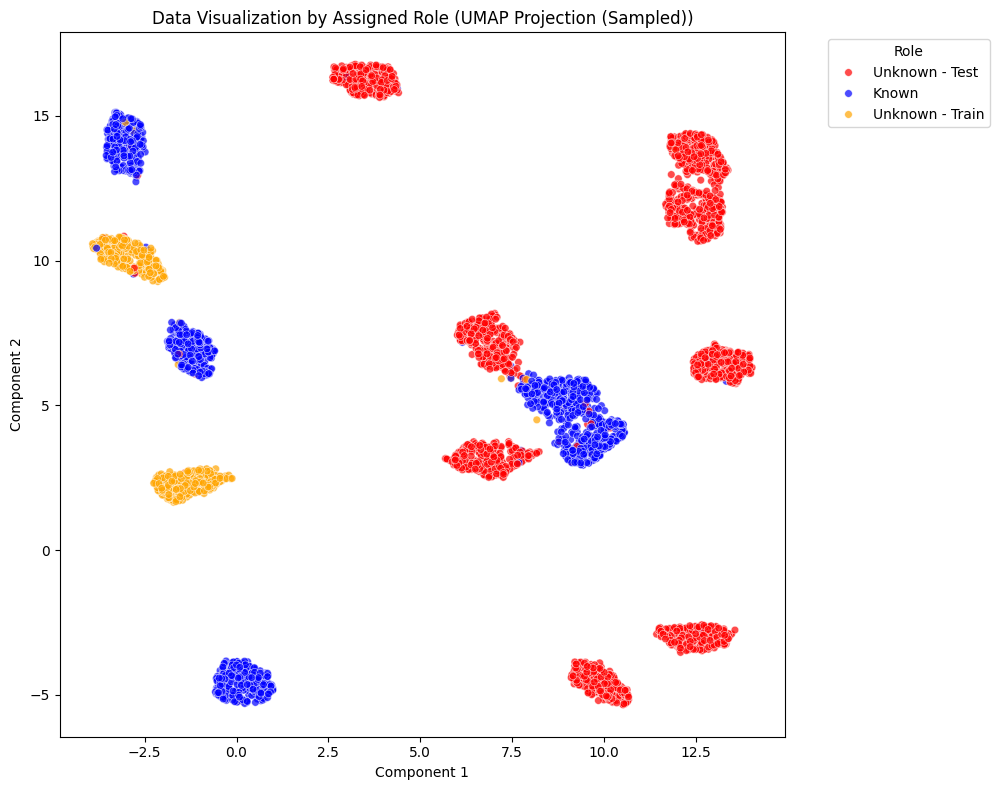


============================== BASELINE (SOFTMAX) ==============================

--- Training Model (Baseline - BASELINE) ---
Epoch 1/50 | Train Loss: 0.3642 | Train Acc (K): 88.61% | Val Loss: 0.0892 | Val Acc (K): 98.06%
Epoch 10/50 | Train Loss: 0.0487 | Train Acc (K): 99.02% | Val Loss: 0.0565 | Val Acc (K): 98.94%
Epoch 20/50 | Train Loss: 0.0367 | Train Acc (K): 99.28% | Val Loss: 0.0594 | Val Acc (K): 98.85%
Epoch 30/50 | Train Loss: 0.0322 | Train Acc (K): 99.32% | Val Loss: 0.0615 | Val Acc (K): 98.94%
Epoch 40/50 | Train Loss: 0.0284 | Train Acc (K): 99.39% | Val Loss: 0.0725 | Val Acc (K): 98.92%
Epoch 50/50 | Train Loss: 0.0226 | Train Acc (K): 99.40% | Val Loss: 0.0760 | Val Acc (K): 98.87%
Training finished for Baseline.

--- Evaluating Baseline ---

--- Baseline: Classification Report (Known Classes Only - Mapped Labels 0-4) ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       832
           1       0.99      0.99

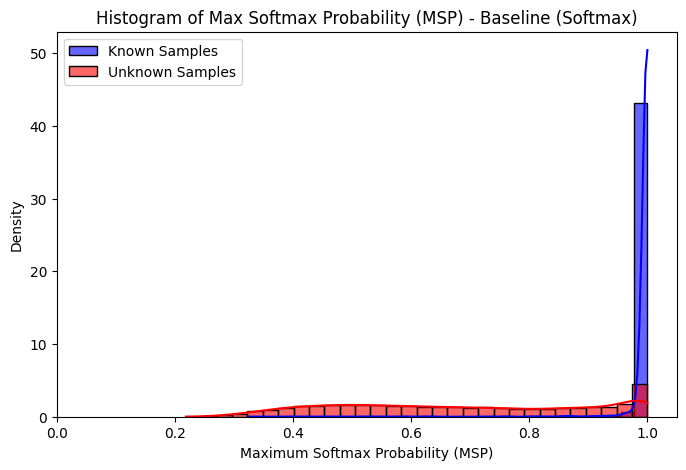


Generating Feature Magnitude Histogram: Baseline (Softmax)


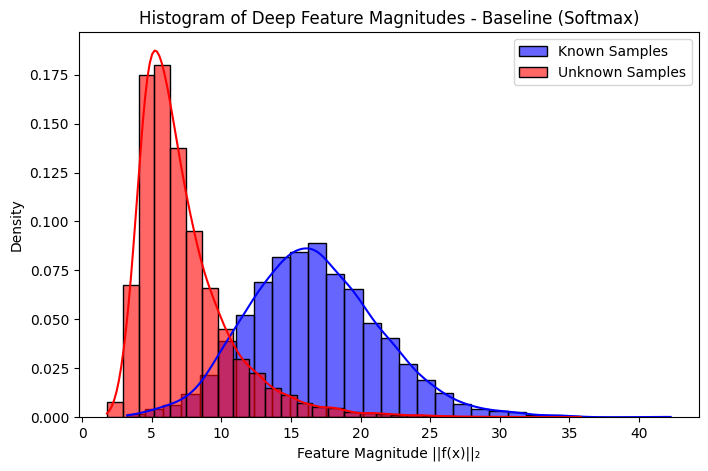


Generating MSP Histogram: Entropic Open-Set (EOS)


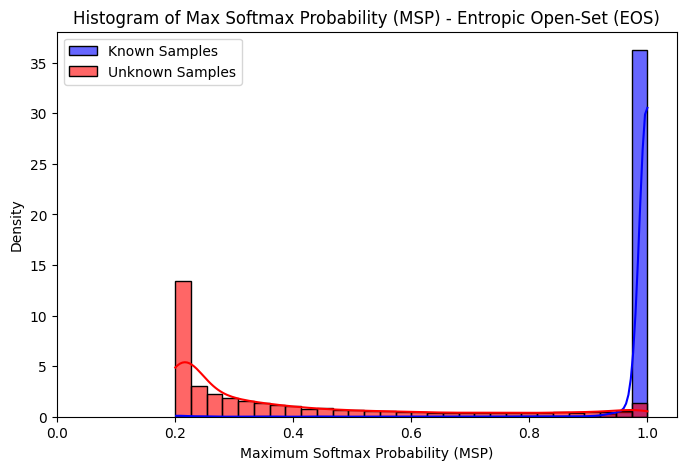


Generating Feature Magnitude Histogram: Entropic Open-Set (EOS)


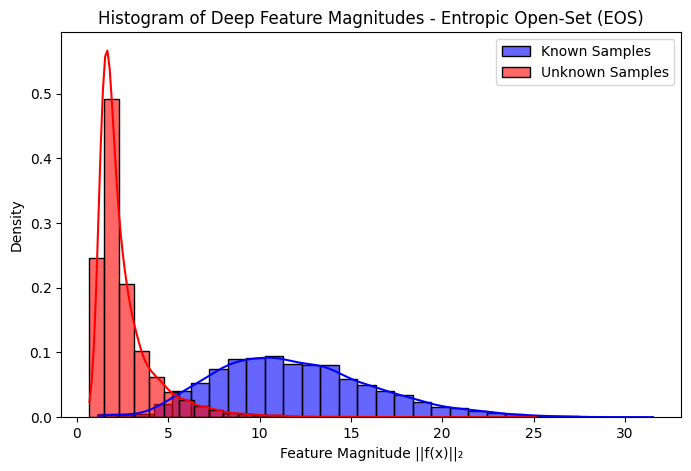


Generating MSP Histogram: Objectosphere (Orig λ=0.1, ξ=20.0)


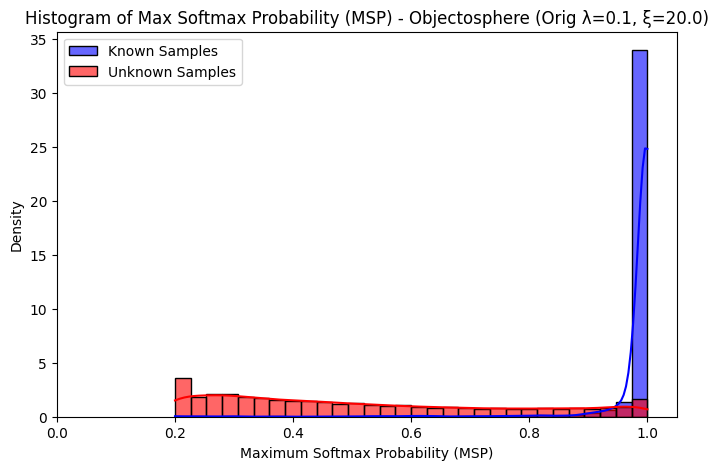


Generating Feature Magnitude Histogram: Objectosphere (Orig λ=0.1, ξ=20.0)


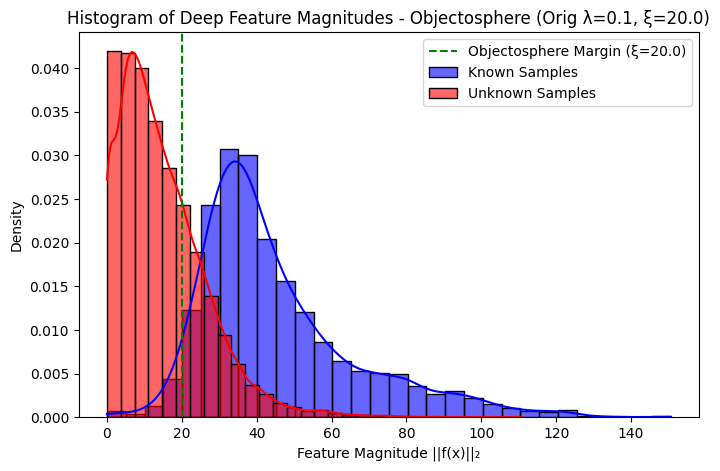


Generating MSP Histogram: Objectosphere (Tuned λ=0.1, ξ=5.0)


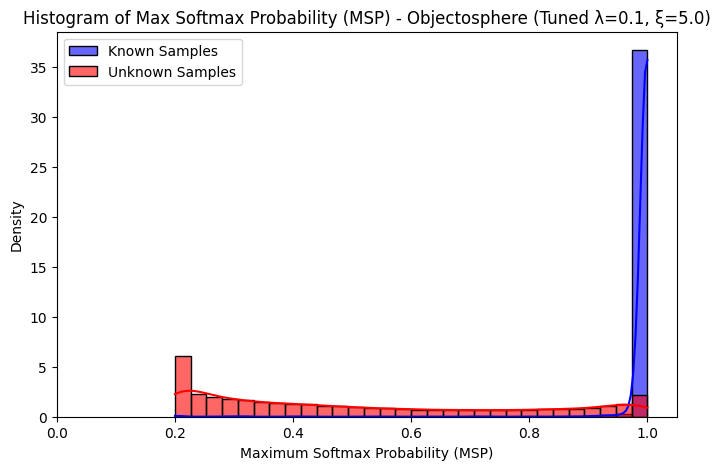


Generating Feature Magnitude Histogram: Objectosphere (Tuned λ=0.1, ξ=5.0)


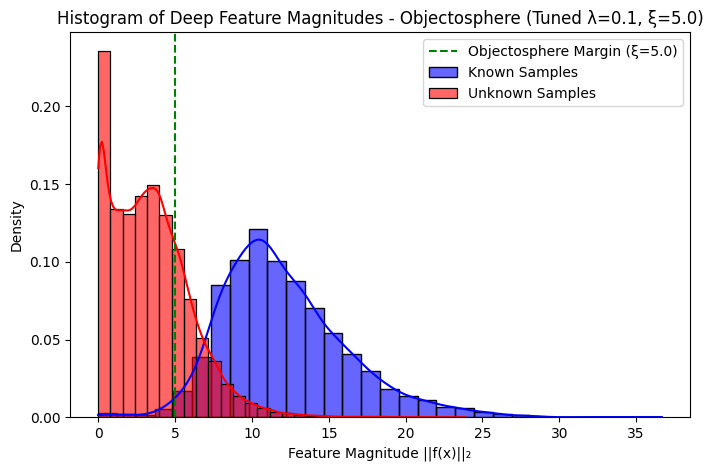


Experiment Complete. Showing plots...

End of script.


In [25]:
# --- 9. Main Execution ---
if __name__ == "__main__":

    # Generate Data
    X_orig, y_orig = generate_data(N_SAMPLES, N_FEATURES, N_CLASSES_TOTAL, N_CLUSTERS_PER_CLASS, CLASS_SEP, SEED)

    # Prepare Data (returns loaders and class indices)
    (train_loader, val_loader, test_loader, input_dim, scaler,
     known_classes_indices, unknown_train_indices, unknown_test_indices) = load_and_prepare_data(
         X_orig, y_orig, N_CLASSES_TOTAL, NUM_KNOWN_CLASSES,
         NUM_UNKNOWN_TRAIN_CLASSES, NUM_UNKNOWN_TEST_CLASSES,
         UNKNOWN_LABEL_MAP, SEED
     )

    # Plot the initial class split visualization
    plot_class_split_visualization(X_orig, y_orig, known_classes_indices, unknown_train_indices, unknown_test_indices)

    # --- Baseline Model ---
    print("\n" + "="*30 + " BASELINE (SOFTMAX) " + "="*30)
    model_baseline = MLP(input_dim, HIDDEN_DIM1, HIDDEN_DIM2, FEATURE_DIM, NUM_KNOWN_CLASSES).to(DEVICE)
    # Baseline uses standard CE and NEEDS bias in the final layer
    model_baseline.classifier = nn.Linear(FEATURE_DIM, NUM_KNOWN_CLASSES, bias=True).to(DEVICE)
    optimizer_baseline = optim.Adam(model_baseline.parameters(), lr=LEARNING_RATE)
    criterion_baseline = nn.CrossEntropyLoss()

    model_baseline = train_model(model_baseline, train_loader, val_loader, criterion_baseline, optimizer_baseline, EPOCHS, DEVICE, loss_type='baseline', model_label="Baseline", verbose=True)
    results_baseline = evaluate_openset(model_baseline, test_loader, DEVICE, NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, model_label="Baseline")


    # --- EOS Model ---
    print("\n" + "="*30 + " ENTROPIC OPEN-SET (EOS) " + "="*30)
    model_eos = MLP(input_dim, HIDDEN_DIM1, HIDDEN_DIM2, FEATURE_DIM, NUM_KNOWN_CLASSES).to(DEVICE) # bias=False
    optimizer_eos = optim.Adam(model_eos.parameters(), lr=LEARNING_RATE)
    criterion_eos = EntropicOpenSetLoss(NUM_KNOWN_CLASSES)

    model_eos = train_model(model_eos, train_loader, val_loader, criterion_eos, optimizer_eos, EPOCHS, DEVICE, loss_type='eos', model_label="EOS", verbose=True)
    results_eos = evaluate_openset(model_eos, test_loader, DEVICE, NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, model_label="EOS")


    # --- Original Objectosphere Model ---
    print("\n" + "="*30 + " OBJECTOSPHERE (ORIGINAL PARAMS) " + "="*30)
    model_obj_orig = MLP(input_dim, HIDDEN_DIM1, HIDDEN_DIM2, FEATURE_DIM, NUM_KNOWN_CLASSES).to(DEVICE) # bias=False
    optimizer_obj_orig = optim.Adam(model_obj_orig.parameters(), lr=LEARNING_RATE)
    criterion_obj_orig = ObjectosphereLoss(NUM_KNOWN_CLASSES, LAMBDA_OBJ_ORIG, XI_OBJ_ORIG) # Use original params

    model_obj_orig = train_model(model_obj_orig, train_loader, val_loader, criterion_obj_orig, optimizer_obj_orig, EPOCHS, DEVICE, loss_type='objectosphere', model_label="Objectosphere-Orig", verbose=True)
    results_obj_orig = evaluate_openset(model_obj_orig, test_loader, DEVICE, NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, model_label="Objectosphere-Orig")


    # --- Hyperparameter Tuning for Objectosphere ---
    best_obj_params = tune_objectosphere_hyperparameters(
        PARAM_GRID, input_dim, train_loader, val_loader, DEVICE,
        NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, EPOCHS_TUNE
    )
    tuned_lambda = best_obj_params['lambda_obj']
    tuned_xi = best_obj_params['xi_obj']


    # --- Data-Tuned Objectosphere Model ---
    print("\n" + "="*30 + " OBJECTOSPHERE (DATA-TUNED PARAMS) " + "="*30)
    model_obj_tuned = MLP(input_dim, HIDDEN_DIM1, HIDDEN_DIM2, FEATURE_DIM, NUM_KNOWN_CLASSES).to(DEVICE) # bias=False
    optimizer_obj_tuned = optim.Adam(model_obj_tuned.parameters(), lr=LEARNING_RATE)
    criterion_obj_tuned = ObjectosphereLoss(NUM_KNOWN_CLASSES, tuned_lambda, tuned_xi)

    model_obj_tuned = train_model(model_obj_tuned, train_loader, val_loader, criterion_obj_tuned, optimizer_obj_tuned, EPOCHS, DEVICE, loss_type='objectosphere', model_label="Objectosphere-Tuned", verbose=True)
    results_obj_tuned = evaluate_openset(model_obj_tuned, test_loader, DEVICE, NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, model_label="Objectosphere-Tuned")


    # --- Evaluate Experiment Success ---
    if test_loader: # Only evaluate if evaluation was possible
        success_summary = evaluate_experiment_success(results_baseline, results_eos, results_obj_orig, results_obj_tuned)
        print("\n" + "="*30 + " EXPERIMENT SUCCESS SUMMARY " + "="*30)
        print(success_summary)
        print("="*80)
    else:
        print("\nSkipping experiment success evaluation as test data was not available.")


    # --- Generate Plots ---
    if test_loader:
        print("\n--- Generating Final Plots ---")
        plt.close('all')

        if results_baseline:
            #plot_tsne(results_baseline['features'], results_baseline['labels'], NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, 'Baseline (Softmax)')
            plot_msp_histogram(results_baseline['msp'], results_baseline['labels'], NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, 'Baseline (Softmax)')
            plot_feature_magnitude_histogram(results_baseline['features'], results_baseline['labels'], NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, 'Baseline (Softmax)')

        if results_eos:
            #plot_tsne(results_eos['features'], results_eos['labels'], NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, 'Entropic Open-Set (EOS)')
            plot_msp_histogram(results_eos['msp'], results_eos['labels'], NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, 'Entropic Open-Set (EOS)')
            plot_feature_magnitude_histogram(results_eos['features'], results_eos['labels'], NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, 'Entropic Open-Set (EOS)')

        if results_obj_orig:
            title_orig=f'Objectosphere (Orig λ={LAMBDA_OBJ_ORIG}, ξ={XI_OBJ_ORIG})'
            #plot_tsne(results_obj_orig['features'], results_obj_orig['labels'], NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, title_orig)
            plot_msp_histogram(results_obj_orig['msp'], results_obj_orig['labels'], NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, title_orig)
            plot_feature_magnitude_histogram(results_obj_orig['features'], results_obj_orig['labels'], NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, title_orig, xi_obj=XI_OBJ_ORIG)

        if results_obj_tuned:
            title_tuned=f'Objectosphere (Tuned λ={tuned_lambda}, ξ={tuned_xi})'
            #plot_tsne(results_obj_tuned['features'], results_obj_tuned['labels'], NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, title_tuned)
            plot_msp_histogram(results_obj_tuned['msp'], results_obj_tuned['labels'], NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, title_tuned)
            plot_feature_magnitude_histogram(results_obj_tuned['features'], results_obj_tuned['labels'], NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, title_tuned, xi_obj=tuned_xi)

        print("\nExperiment Complete. Showing plots...")
        plt.show() # Display all generated plots at the end
    else:
        print("\nSkipping plot generation as test data was not available.")

    print("\nEnd of script.")

In [30]:
!pip install -U kaleido

### Creating Representative Image

In [32]:
import plotly.graph_objects as go
import numpy as np

np.random.seed(42)

# Known class centers
centers = np.array([[2, 2], [6, 2], [4, 6], [7, 7], [1, 7]])
colors = ['royalblue', 'seagreen', 'darkorange', 'orchid', 'goldenrod']
labels = ['Class A', 'Class B', 'Class C', 'Class D', 'Class E']

# Generate known class points
known_points = []
for center in centers:
    points = np.random.normal(loc=center, scale=0.4, size=(100, 2))
    known_points.append(points)

# Create multiple clusters for unknown points, each larger and denser
unknown_centers = np.array([[8, 8], [3, 2], [1, 4], [6, 8], [5, 5]])  # Centers for unknown clusters
unknown_points = []

# Generate unknown points around these centers with larger spread
for center in unknown_centers:
    points = np.random.normal(loc=center, scale=0.6, size=(200, 2))  # Larger scale for more spread
    unknown_points.append(points)

# Combine all unknown points
unknown = np.vstack(unknown_points)

# Create figure
fig = go.Figure()

# Plot known class clusters
for i, points in enumerate(known_points):
    fig.add_trace(go.Scatter(
        x=points[:, 0], y=points[:, 1],
        mode='markers',
        marker=dict(color=colors[i], size=6, opacity=0.7),
        name=labels[i]
    ))

# Plot unknown samples
fig.add_trace(go.Scatter(
    x=unknown[:, 0], y=unknown[:, 1],
    mode='markers',
    marker=dict(color='crimson', symbol='x', size=9),
    name='Unknown Reality'
))

# Arrows: Softmax pull toward nearest known
arrow_annotations = []
for pt in unknown[::8]:  # sample fewer for clarity
    nearest_center = centers[np.argmin([np.linalg.norm(pt - c) for c in centers])]
    arrow_annotations.append(dict(
        ax=pt[0], ay=pt[1],
        x=pt[0] + (nearest_center[0] - pt[0]) * 0.5,
        y=pt[1] + (nearest_center[1] - pt[1]) * 0.5,
        xref='x', yref='y', axref='x', ayref='y',
        showarrow=True,
        arrowhead=2,
        arrowsize=1,
        arrowwidth=1,
        opacity=0.5,
        arrowcolor='gray'
    ))

# Add message
fig.add_annotation(
    text="Softmax World: Everything fits a label\nReality: Some things truly don’t belong",
    x=4.5, y=9.2,
    showarrow=False,
    font=dict(size=14, color="black"),
    align='center',
    bgcolor='white',
    bordercolor='gray',
    borderwidth=1,
    borderpad=10
)

# Layout settings
fig.update_layout(
    title=dict(
        text="<b>Softmax World vs. Unknown Reality</b>",
        font=dict(size=20, color='black'),
        x=0.5
    ),
    annotations=arrow_annotations,
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    showlegend=True,
    legend=dict(font=dict(color='black')),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Save the figure as a high-resolution image (scale=4 increases resolution)
fig.write_image("softmax_vs_unknown_reality_high_res.png", scale=4, width=1200, height=900)

# Show the plot interactively
fig.show()
